### Example 1: cylindrical object

A cylindrical object illuminated by a plane wave $Ae^{i\vec{k}\cdot\vec{r}}$.
The size of the physical domain $\Omega_{\text{p}}$ is $[-8.0, 12.0] \times [-8.0, 12.0]$ mm$^2$, and the grid spacing is uniform in both the x- and y-directions, and is set to $h = 0.1$ mm

In [3]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt

# from fdfdv5 import FDFD_hybrid_v5
import pyfdfd
from mie2D import mie_solution

In [4]:
def round_to_int(m):    
    if (m-int(m) >= 0.5): mr = np.ceil(m).astype(int)
    else: mr = np.floor(m).astype(int)    
    return mr

In [5]:
WLEN = 3.0e-3
FREQ = 299792458/WLEN
K0 = 2*np.pi/WLEN
SCALE = 1.0e-3

GS = 0.2e-3
typeHHorder = '2nd'
# typeHHorder = '4th'

nly = 10 #round_to_int(WLEN/GS)
sigma_0 = 0.0

# planewave 's parameters
amp, xsrc, ysrc = 1.0, 0.0e-3, 0.0e-3
thetainc = 30 # [deg]

# circular object's parameters
xc, yc = np.copy(xsrc), np.copy(ysrc) # with the condition, xsrc = xc and ysrc = yc
radius, epsrmat = 5.0e-3, 2.0#+0.5j 
geometry = xc, yc, radius

# FD 's parameters
typeOWorder, typeWeight, typeK, typeDamp = '2nd_bw_2nd', 'quadratic', '1', 'non'

# Physical domain
xHHmin, xHHmax = -8.0e-3, 12.0e-3
yHHmin, yHHmax = -8.0e-3, 12.0e-3

In [6]:
thk = GS*nly

nxHH, nyHH = round_to_int((xHHmax-xHHmin)/GS) + 1, round_to_int((yHHmax-yHHmin)/GS) + 1
nHH = nxHH*nyHH
  
xHH = np.linspace(xHHmin, xHHmax, nxHH)
yHH = np.linspace(yHHmin, yHHmax, nyHH)
ExtHH = np.array([xHHmin, xHHmax, yHHmin, yHHmax])/SCALE

In [7]:
print(f'npoint = {nly} + nHH = {nHH}')

npoint = 10 + nHH = 10201


In [8]:
# analytical solution
def compute_miesolution(xdom, ydom, xc, yc, radius, epsrmat, WLEN, xsrc, ysrc, thetainc):
    
    xHHmin, xHHmax, dx = xdom
    yHHmin, yHHmax, dy = ydom
    nxHH, nyHH = round_to_int((xHHmax-xHHmin)/GS) + 1, round_to_int((yHHmax-yHHmin)/GS) + 1
    xHH, yHH = np.linspace(xHHmin, xHHmax, nxHH), np.linspace(yHHmin, yHHmax, nyHH)
    XHH, YHH = np.meshgrid(xHH, yHH)

    k0, morder = 2*np.pi/WLEN, 150
    kx, ky = k0*np.cos(np.deg2rad(thetainc)), k0*np.sin(np.deg2rad(thetainc))

    Utot2D_ana = mie_solution(XHH, YHH, xc, yc, morder, radius, k0, epsrmat, thetainc)
    Utot1D_ana  = Utot2D_ana.flatten()
    
    Uinc1D = ( amp*np.exp(1j*kx*(XHH-xsrc))*np.exp(1j*ky*(YHH-ysrc)) ).flatten()
    Uscat1D_ana = Utot1D_ana - Uinc1D
    Uscat2D_ana = Uscat1D_ana.reshape([nyHH, nxHH])
    
    return Uscat2D_ana

In [10]:
sim = PyFDFD.simulation(FREQ, GS)
sim.domain(xHHmin, xHHmax, yHHmin, yHHmax, thk)
sim.create_scatterer('circle', geometry, epsrmat)
sim.source(('PLANEWAVE', amp, xsrc, ysrc, thetainc))

Uinc2D_full, Uscat2D_full, Utot2D_full = sim.solve_HH(typeHHorder, typeOWorder, 'quadratic', typeK, typeDamp, sigma_0)
Uinc2D_sim, Uscat2D_sim, Utot2D_sim  = Uinc2D_full[nly:-nly, nly:-nly], Uscat2D_full[nly:-nly, nly:-nly], Utot2D_full[nly:-nly, nly:-nly]

Uscat2D_ana = compute_miesolution([xHHmin, xHHmax, GS], [yHHmin, yHHmax, GS], xc, yc, radius, epsrmat, WLEN, xsrc, ysrc, thetainc)

TypeError: cannot unpack non-iterable float object

epsrmat = 2.0
orderHH = 4th
score = 0.00019147 + npoint = 30
score = 2.7813076724563226 + npoint = 30


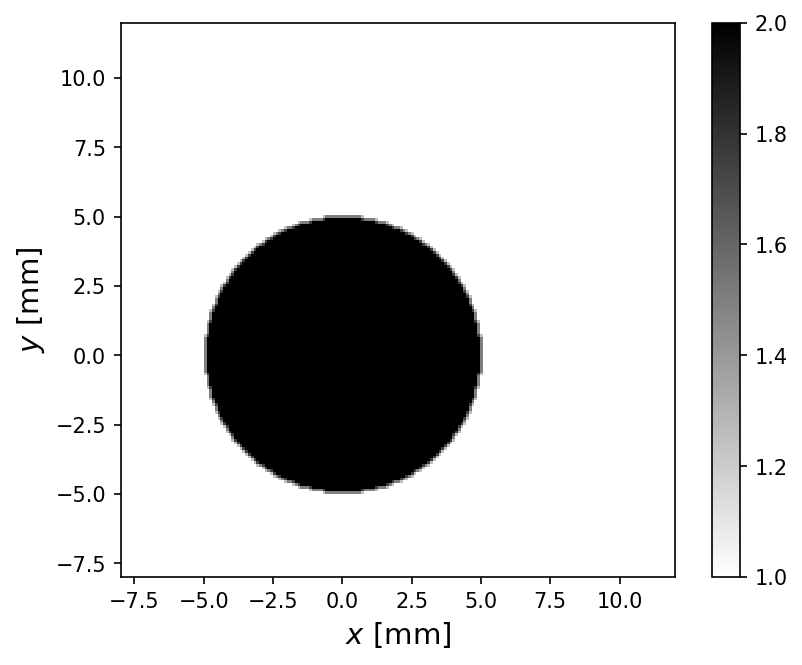

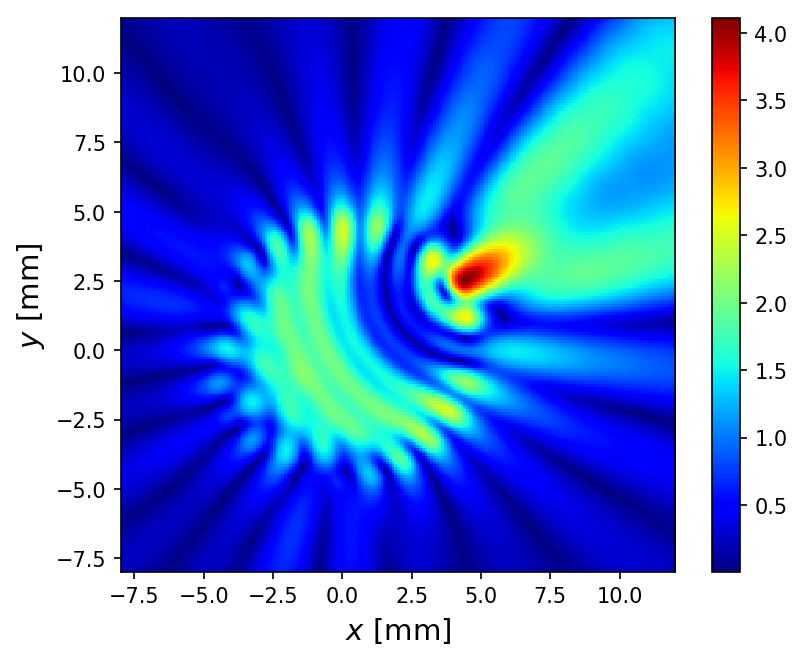

In [13]:
print(f'epsrmat = {epsrmat}')
print(f'orderHH = {typeHHorder}')
print(f'score = {np.linalg.norm(Uscat2D_sim - Uscat2D_ana)**2 / nHH:.8f} + npoint = {round_to_int(WLEN/GS)}')
print(f'score = {np.linalg.norm(Uscat2D_sim - Uscat2D_ana)} + npoint = {round_to_int(WLEN/GS)}')

plt.figure(dpi=150); plt.imshow(np.flipud(np.abs(sim.MatHH2D)), extent=ExtHH, cmap='binary')
plt.xlabel(r'$x$ [mm]', fontsize=14); plt.ylabel(r'$y$ [mm]', fontsize=14); plt.colorbar(); plt.show()
# plt.figure(dpi=50); plt.imshow(np.flipud(np.abs(Uscat2D_ana)), extent=ExtHH, cmap='jet')
# plt.title(r'the magnitude of the analytical scattered field ($h$' + f' = {GS/SCALE} mm)'); plt.xlabel(r'$x$ [mm]'); plt.ylabel(r'$y$ [mm]'); plt.colorbar(); plt.show()
plt.figure(dpi=150); plt.imshow(np.flipud(np.abs(Uscat2D_sim)), extent=ExtHH, cmap='jet')
# plt.title(r'the magnitude of the simulated scattered field ($h$' + f' = {GS/SCALE} mm)')
plt.xlabel(r'$x$ [mm]', fontsize=14); plt.ylabel(r'$y$ [mm]', fontsize=14); plt.colorbar(); plt.show()
# plt.figure(dpi=50); plt.imshow(np.flipud(np.abs(Utot2D_sim)), extent=ExtHH, cmap='jet')
# plt.title(r'the magnitude of the simulated scattered field ($h$' + f' = {GS/SCALE} mm)'); plt.xlabel(r'$x$ [mm]'); plt.ylabel(r'$y$ [mm]'); plt.colorbar(); plt.show()

# Sy = np.imag( (1/K0)*np.conjugate(Uscat2D_sim)*np.gradient(Uscat2D_sim, axis=0) )
# Sx = np.imag( (1/K0)*np.conjugate(Uscat2D_sim)*np.gradient(Uscat2D_sim, axis=1) )
# S = np.sqrt(Sx**2 + Sy**2)
# step = 11; plt.quiver(xHH[::step], yHH[::step], (Sx[::step, ::step]), (Sy[::step, ::step]))
# plt.title(r'the Poynting vector of the scattered field ($h$' + f' = {GS/SCALE} mm)'); plt.xlabel(r'$x$ [mm]'); plt.ylabel(r'$y$ [mm]'); plt.show()

# Sy = np.imag( (1/K0)*np.conjugate(Utot2D_sim)*np.gradient(Utot2D_sim, axis=0) )
# Sx = np.imag( (1/K0)*np.conjugate(Utot2D_sim)*np.gradient(Utot2D_sim, axis=1) )
# S = np.sqrt(Sx**2 + Sy**2)
# step = 20; plt.quiver(xHH[::step], yHH[::step], (Sx[::step, ::step]), (Sy[::step, ::step]))
# plt.title(r'the Poynting vector of the total field ($h$' + f' = {GS/SCALE} mm)'); plt.xlabel(r'$x$ [mm]'); plt.ylabel(r'$y$ [mm]'); plt.show()

In [19]:
# txtnp = str(round_to_int(WLEN/GS))
# np.save('Uscat2D_ana_np_' + txtnp + '.npy', Uscat2D_ana)

# epsrmat = 1.2
# score_2nd = np.array([1.19308330, 0.86298479, 0.42626650, 0.13855548, 0.02652122, 0.00823301, 0.00160700])
# score_4th = np.array([0.09453361, 0.02105955, 0.00521897, 0.00070891, 0.00004555, 0.00001449, 0.00000614])
# npoint = np.array([5, 6, 8, 10, 15, 20, 30])

### HABC vs $N$

In [10]:
nlymin, nlymax = 1, 30
nlystep = 1
Nly, Score_HABC, Score_ABC = [], [], []

for nly in range(nlymin, nlymax+1, nlystep):
    
    thk = nly*GS

    nx, ny = nxHH + 2*nly, nyHH + 2*nly
    x = np.linspace(xHHmin-thk, xHHmax+thk, nx)
    y = np.linspace(yHHmin-thk, yHHmax+thk, ny)

    Ext = np.array([xHHmin-thk, xHHmax+thk, yHHmin-thk, yHHmax+thk]) / SCALE

    sim = FDFD_hybrid_v5(FREQ, GS);   
    sim.domain(xHHmin, xHHmax, yHHmin, yHHmax, thk)
    sim.create_scatterer('circle', geometry, epsrmat)
    sim.source(('PLANEWAVE', amp, xsrc, ysrc, thetainc))

    ####################################################################################
    Uinc2D_full, Uscat2D_full, Utot2D_full = sim.solve_HH(typeHHorder, typeOWorder, 'quadratic', typeK, typeDamp, sigma_0)    
    Uinc2D_sim, Uscat2D_sim, Utot2D_sim  = Uinc2D_full[nly:-nly, nly:-nly], Uscat2D_full[nly:-nly, nly:-nly], Utot2D_full[nly:-nly, nly:-nly]
    
    ny, nx = Uscat2D_full.shape 

    score = np.linalg.norm(Uscat2D_ana-Uscat2D_sim) / np.linalg.norm(Uscat2D_ana)
    Score_HABC = np.append(Score_HABC, score)    
    ####################################################################################
    Uinc2D_full, Uscat2D_full, Utot2D_full = sim.solve_HH(typeHHorder, typeOWorder, 'zero', typeK, typeDamp, sigma_0)    
    Uinc2D_sim, Uscat2D_sim, Utot2D_sim  = Uinc2D_full[nly:-nly, nly:-nly], Uscat2D_full[nly:-nly, nly:-nly], Utot2D_full[nly:-nly, nly:-nly]
    
    ny, nx = Uscat2D_full.shape  

    score = np.linalg.norm(Uscat2D_ana-Uscat2D_sim) / np.linalg.norm(Uscat2D_ana)
    Score_ABC = np.append(Score_ABC, score)
    ####################################################################################
    
    Nly = np.append(Nly, nly)

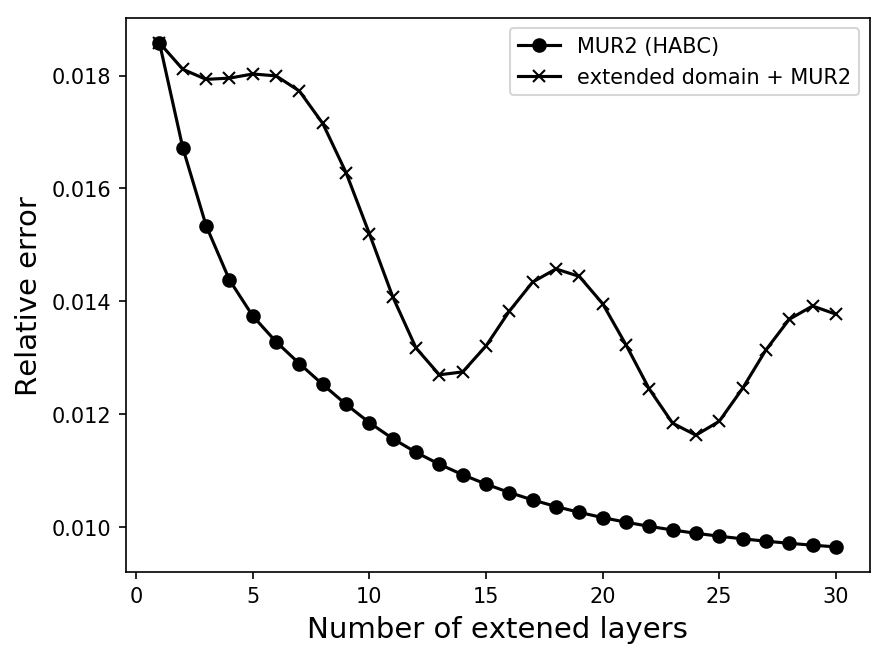

In [14]:
fig, ax = plt.subplots(dpi=150)
plt.plot(Nly, Score_HABC, 'ko-', label='MUR2 (HABC)')
plt.plot(Nly, Score_ABC, 'kx-', label='extended domain + MUR2')
plt.xlabel(r'Number of extened layers', fontsize=14)
plt.ylabel('Relative error', fontsize=14)
# plt.title(f'GS/typeHHorder = {GS/SCALE} mm/{typeHHorder}')
# plt.ylim([5.9e-2, 6.3e-2])
plt.legend(); plt.show()

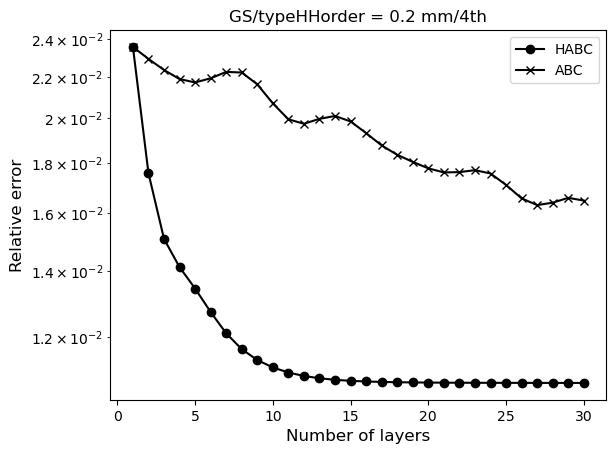

In [134]:
fig, ax = plt.subplots()
plt.semilogy(Nly, Score_HABC, 'ko-', label='HABC')
plt.semilogy(Nly, Score_ABC, 'kx-', label='ABC')
plt.xlabel(r'Number of layers', fontsize=12)
plt.ylabel('Relative error', fontsize=12)
plt.title(f'GS/typeHHorder = {GS/SCALE} mm/{typeHHorder}')
# plt.ylim([5.9e-2, 6.3e-2])
plt.legend(); plt.show()

In [124]:
nly = 1; sim = FDFD_hybrid_v5(FREQ, GS); sim.domain(xHHmin, xHHmax, yHHmin, yHHmax, GS*nly)
sim.create_scatterer('circle', geometry, epsrmat); sim.source(('PLANEWAVE', amp, xsrc, ysrc, thetainc))
_, Uscat2D_full, _ = sim.solve_HH('4th', typeOWorder, 'quadratic', typeK, typeDamp, sigma_0)
Uscat2D_sim_nly_1 = Uscat2D_full[nly:-nly, nly:-nly]

nly = 15; sim = FDFD_hybrid_v5(FREQ, GS); sim.domain(xHHmin, xHHmax, yHHmin, yHHmax, GS*nly)
sim.create_scatterer('circle', geometry, epsrmat); sim.source(('PLANEWAVE', amp, xsrc, ysrc, thetainc))
_, Uscat2D_full, _ = sim.solve_HH('4th', typeOWorder, 'quadratic', typeK, typeDamp, sigma_0)
Uscat2D_sim_nly_15 = Uscat2D_full[nly:-nly, nly:-nly]

nly = 30; sim = FDFD_hybrid_v5(FREQ, GS); sim.domain(xHHmin, xHHmax, yHHmin, yHHmax, GS*nly)
sim.create_scatterer('circle', geometry, epsrmat); sim.source(('PLANEWAVE', amp, xsrc, ysrc, thetainc))
_, Uscat2D_full, _ = sim.solve_HH('4th', typeOWorder, 'quadratic', typeK, typeDamp, sigma_0)
Uscat2D_sim_nly_30 = Uscat2D_full[nly:-nly, nly:-nly]

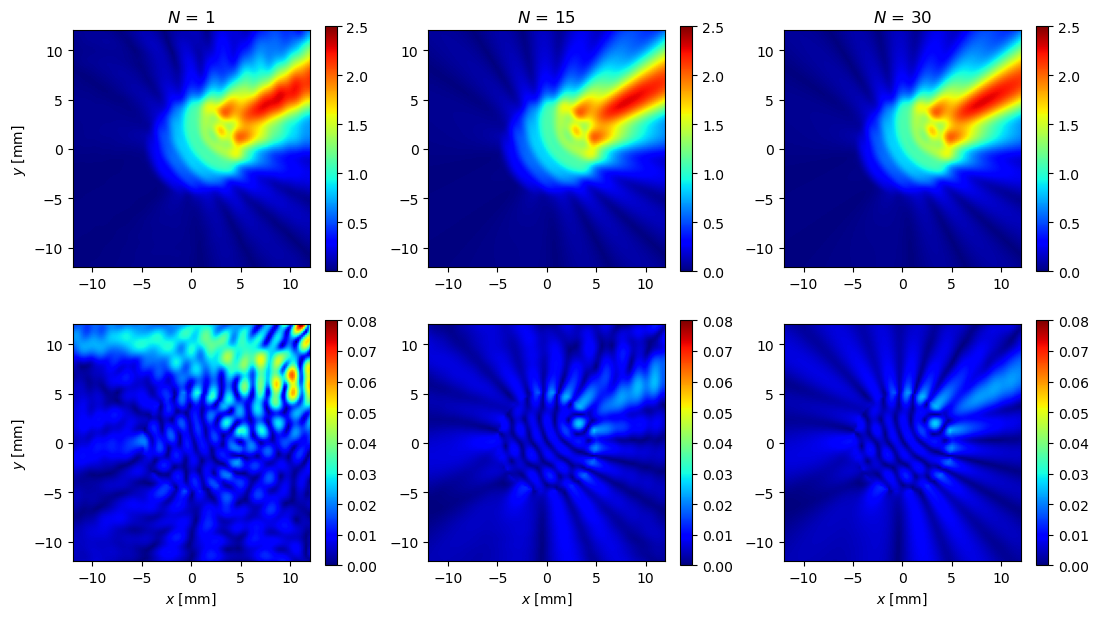

In [132]:
fig, ax = plt.subplots(2, 3, figsize=(13, 7))

f1 = ax[0,0].imshow(np.flipud(np.abs(Uscat2D_sim_nly_1)), cmap='jet', vmin=0.0, vmax=2.5, extent=ExtHH); plt.colorbar(f1, ax=ax[0,0])
f2 = ax[0,1].imshow(np.flipud(np.abs(Uscat2D_sim_nly_15)), cmap='jet', vmin=0.0, vmax=2.5, extent=ExtHH); plt.colorbar(f2, ax=ax[0,1])
f3 = ax[0,2].imshow(np.flipud(np.abs(Uscat2D_sim_nly_30)), cmap='jet', vmin=0.0, vmax=2.5, extent=ExtHH); plt.colorbar(f3, ax=ax[0,2])

f4 = ax[1,0].imshow(np.flipud(np.abs(Uscat2D_sim_nly_1-Uscat2D_ana)), cmap='jet', vmin=0.0, vmax=0.08, extent=ExtHH); plt.colorbar(f4, ax=ax[1,0])
f5 = ax[1,1].imshow(np.flipud(np.abs(Uscat2D_sim_nly_15-Uscat2D_ana)), cmap='jet', vmin=0.0, vmax=0.08, extent=ExtHH); plt.colorbar(f5, ax=ax[1,1])
f6 = ax[1,2].imshow(np.flipud(np.abs(Uscat2D_sim_nly_30-Uscat2D_ana)), cmap='jet', vmin=0.0, vmax=0.08, extent=ExtHH); plt.colorbar(f6, ax=ax[1,2])

ax[0,0].set_ylabel(r'$y$ [mm]')
ax[1,0].set_xlabel(r'$x$ [mm]'); ax[1,0].set_ylabel(r'$y$ [mm]')
ax[1,1].set_xlabel(r'$x$ [mm]')
ax[1,2].set_xlabel(r'$x$ [mm]') 

ax[0,0].set_title(r'$N$ = 1')
ax[0,1].set_title(r'$N$ = 15')
ax[0,2].set_title(r'$N$ = 30')

plt.show()

In [ ]:
plt.title(f'nx/nxHH/nly = {nx}/{nxHH}/{nly}')
plt.imshow(np.flipud(np.abs(Uscat2D_full)), cmap='jet', extent=Ext);
plt.plot(xline, yline, 'w--'); plt.colorbar(); plt.show()

plt.imshow(np.flipud(np.real(sim.Mat2D)), cmap='jet', extent=Ext)
plt.plot(xline, yline, 'w--'); plt.colorbar(); plt.show()

In [ ]:
# plt.plot(np.abs(Uscat2D_sim1)[90, :][::3], 'o-', label=f'{GS1/SCALE}')
# plt.plot(np.abs(Uscat2D_sim2)[30, :], '.-', label=f'{GS2/SCALE}')
# plt.legend()
# plt.show()

In [ ]:
# npoint = np.array([30, 20, 15, 10, 8, 6, 5])
# score_2nd = np.array([0.00200462, 0.01026937, 0.03306997, 0.17264741, 0.53079841, 1.07337785, 1.48161192])
# score_4th = np.array([0.00000673, 0.00001438, 0.00004990, 0.00084215, 0.00639137, 0.02601149, 0.11664509])
plt.title(r'a circular object at (0, 0) mm with $R$ = 6 mm and $\epsilon_r$ = 1.2')
plt.semilogy(npoint, (score_2nd), 'o-', label='2nd order of FD')
plt.semilogy(npoint, (score_4th), 'o-', label='4th order of FD')
plt.xlabel(r'$\lambda/\Delta$'); plt.ylabel('MSE')
plt.legend(); plt.show()

idx = 1
# nHH =np.array([58081, 25921, 14641, 6561, 3721, 2401, 1681])
# score_2nd = np.array([0.00200462, 0.01026937, 0.03306997, 0.17264741, 0.53079841, 1.07337785, 1.48161192])
# score_4th = np.array([0.00000673, 0.00001438, 0.00004990, 0.00084215, 0.00639137, 0.02601149, 0.11664509])
plt.title(r'a circular object at (-6, 0) mm with $R$ = 6 mm and $\epsilon_r$ = 1.2')
# plt.plot(npoint[:-idx], score_2nd[:-idx], 'o-', label='2nd order of FD')
plt.plot(npoint[:-idx], score_4th[:-idx], 'o-', label='4th order of FD')
plt.xlabel(r'$\lambda/\Delta$'); plt.ylabel('MSE')
plt.legend(); plt.show()

In [ ]:

plt.imshow(np.abs(sim.MatHH2D), extent=Ext, cmap='jet')
plt.xlabel(r'$x$ [mm]'); plt.ylabel(r'$y$ [mm]'); plt.colorbar()

In [ ]:
u1 = np.load('Uscat2D_ana_np_30.npy')
u15 = np.load('Uscat2D_ana_np_20.npy')
u2 = np.load('Uscat2D_ana_np_15.npy')
u3 = np.load('Uscat2D_ana_np_10.npy')
u4 = np.load('Uscat2D_ana_np_8.npy')
u5 = np.load('Uscat2D_ana_np_6.npy')
u6 = np.load('Uscat2D_ana_np_5.npy')

In [ ]:
score_1_2 = np.linalg.norm(u1[::2, ::2]-u2); print(f'{score_1_2:.10f}')
score_1_3 = np.linalg.norm(u1[::3, ::3]-u3); print(f'{score_1_3:.10f}')
score_1_4 = np.linalg.norm(u1[::4, ::4]-u4); print(f'{score_1_4:.10f}')
score_1_5 = np.linalg.norm(u1[::5, ::5]-u5); print(f'{score_1_5:.10f}')
score_1_6 = np.linalg.norm(u1[::6, ::6]-u6); print(f'{score_1_6:.10f}')

score_15_3 = np.linalg.norm(u15[::2, ::2]-u3); print(f'{score_15_3:.10f}')
score_15_6 = np.linalg.norm(u15[::4, ::4]-u6); print(f'{score_15_6:.10f}')

score_2_4 = np.linalg.norm(u2[::2, ::2]-u4); print(f'{score_2_4:.10f}')
score_2_6 = np.linalg.norm(u2[::3, ::3]-u6); print(f'{score_2_6:.10f}')

score_3_6 = np.linalg.norm(u3[::2, ::2]-u6); print(f'{score_3_6:.10f}')
